<a href="https://colab.research.google.com/github/ihawryluk/importations/blob/main/Seasonal_analyse_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SET THE WRITE PROPERTY BEFORE YOU RUN THIS SCRIPT

Decide if you want to overwrite the saved plots or not

In [ ]:
SAVE = True
savepath = '/content/drive/My Drive/Colab Notebooks/importations/Figures/Seasonal/'

# Install and import packages

In [ ]:
!pip install numpyro

In [ ]:
!pip install dill

In [ ]:
!pip install properscoring

In [ ]:
!pip install CRPS

In [ ]:
import numpyro
import jax
numpyro.set_host_device_count(4)  # 4 cores
from jax import vmap
import jax.numpy as jnp
import jax.random as random

from numpyro.infer import Predictive
import numpyro.distributions as dist
import arviz as az
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.control_flow import scan

from scipy.stats import gamma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import arviz as az
import dill
from properscoring import crps_ensemble as crps
# import CRPS.CRPS as crps

from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import mean_squared_error as mse

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load all simulated data and results

In [ ]:
ls /content/drive/MyDrive/Colab\ Notebooks/importations/Data/Seasonal/

mcmc_10e.pkl  mcmc_1.pkl    mcmc_2e.pkl   mcmc_30.pkl  sim_seasonal_mu.csv
mcmc_10.pkl   mcmc_20e.pkl  mcmc_2.pkl    mcmc_3e.pkl  sim_seasonal_Rt.csv
mcmc_1e.pkl   mcmc_20.pkl   mcmc_30e.pkl  mcmc_3.pkl   sim_seasonal_y.csv


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/importations/Data/Seasonal/'

In [ ]:
mu_df = pd.read_csv(path + 'sim_seasonal_mu.csv')
y_df = pd.read_csv(path + 'sim_seasonal_y.csv')
Rt_df = pd.read_csv(path + 'sim_seasonal_Rt.csv')


In [ ]:
# high variance model results default model
with open(path + 'mcmc_1.pkl', 'rb') as f:
    mcmc1 = dill.load(f)
with open(path + 'mcmc_2.pkl', 'rb') as f:
    mcmc2 = dill.load(f)
with open(path + 'mcmc_3.pkl', 'rb') as f:
    mcmc3 = dill.load(f)

# high variance model results explicit model
with open(path + 'mcmc_1e.pkl', 'rb') as f:
    mcmc1e = dill.load(f)
with open(path + 'mcmc_2e.pkl', 'rb') as f:
    mcmc2e = dill.load(f)
with open(path + 'mcmc_3e.pkl', 'rb') as f:
    mcmc3e = dill.load(f)

# low variance model results default model
with open(path + 'mcmc_10.pkl', 'rb') as f:
    mcmc10 = dill.load(f)
with open(path + 'mcmc_20.pkl', 'rb') as f:
    mcmc20 = dill.load(f)
with open(path + 'mcmc_30.pkl', 'rb') as f:
    mcmc30 = dill.load(f)

# low variance model results explicit model
with open(path + 'mcmc_10e.pkl', 'rb') as f:
    mcmc10e = dill.load(f)
with open(path + 'mcmc_20e.pkl', 'rb') as f:
    mcmc20e = dill.load(f)
with open(path + 'mcmc_30e.pkl', 'rb') as f:
    mcmc30e = dill.load(f)


In [ ]:
scenarios_names = ['placeholder',
                   r'$R_t$ as a function of sin(), $\mu$ inferred as GRW',
                   r'$R_t$ as a function of cos(), $\mu$ inferred as GRW',
                   r'$R_t$ constant, $\mu$ inferred as GRW',
                   ]

scenarios_names_e = ['placeholder',
                  r'$R_t$ as a function of sin(), $\mu$ iferred with explicit seasonality with sin()',
                  r'$R_t$ as a function of cos(), $\mu$ iferred with explicit seasonality with sin()',
                  r'$R_t$ constant, $\mu$ iferred with explicit seasonality with sin()'
                   ]

# Plot simulated data

In [ ]:
def plot_sim_R_and_incidence(R, mu, obs, title):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(obs, label = 'all cases')
  plt.plot(mu, label = 'imported cases')
  plt.legend()
  plt.xlabel('day')
  plt.ylabel('# new cases')
  # plt.title('observed cases')
  plt.subplot(1,2,2)
  plt.plot(R, color = 'green', label=r'$R_t$')
  plt.xlabel('day')
  plt.ylabel(r'$R_t$')
  # plt.title('R')
  # plt.suptitle('simulated data')
  plt.tight_layout()

  if SAVE:
    namefile = 'simulated_data_' + title.replace(' ', '_')
    plt.savefig(savepath + namefile + '.pdf', format = 'pdf', bbox_inches = 'tight')

  else:
    plt.show()

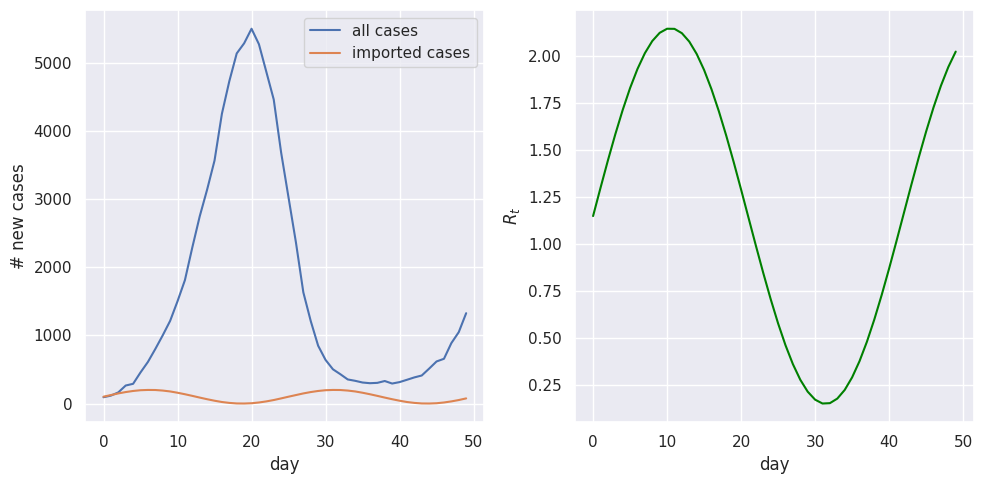

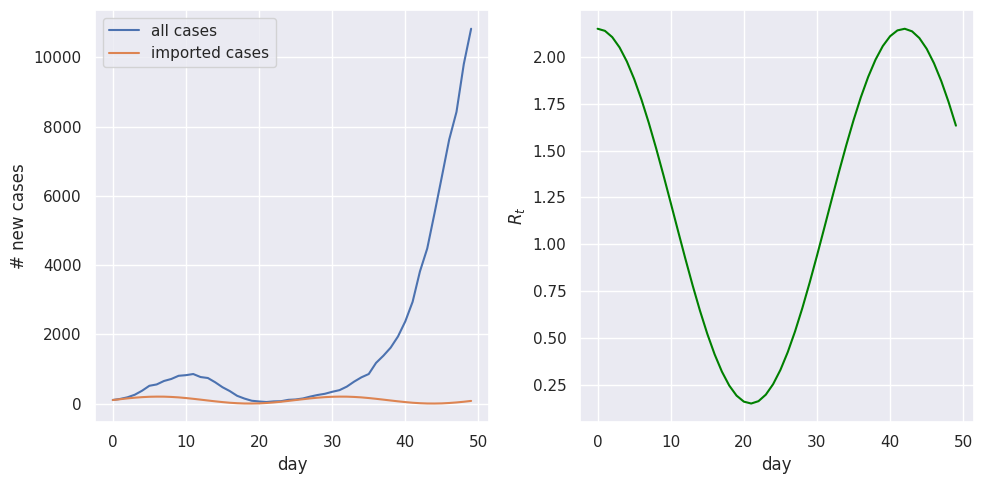

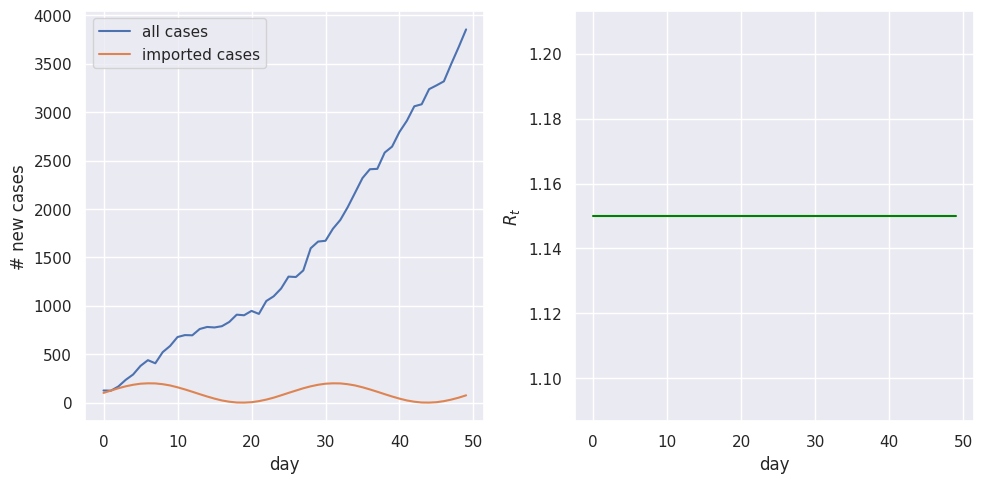

In [ ]:
plot_sim_R_and_incidence(Rt_df['R1'], mu_df['mu1'], y_df['y1'], '$R_t$ as a function of sin()')
plot_sim_R_and_incidence(Rt_df['R2'], mu_df['mu2'], y_df['y2'], '$R_t$ as a function of cos()')
plot_sim_R_and_incidence(Rt_df['R3'], mu_df['mu3'], y_df['y3'], '$R_t$ constant')


# Posteriors


In [ ]:
def plot_posterior_two_samples_no_incidence(mcmc_high, mcmc_low, R, mu, inc, title):

  samples1 = mcmc_high.get_samples()
  samples2 = mcmc_low.get_samples()

  n = samples1['R'].shape[1]
  plt.figure(figsize=(20,5))

  x = np.arange(n)
  plt.subplot(1,4,1)
  # plt.plot(samples['R'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples1['R'], 5, axis=0), np.percentile(samples1['R'], 95, axis=0), alpha=0.3, label='CrI $\hat{R}_t$', color='tab:blue')
  plt.plot(x, np.percentile(samples1['R'], 50, axis=0), label=r'median $\hat{R}_t$', color='tab:blue')
  plt.plot(R, color = 'red', alpha=1.0, label = r'true $R_t$')
  plt.legend()
  plt.ylim(-0.5,14)
  plt.xlabel('day')
  plt.ylabel(r'$R_t$')
  plt.title(r'$R_t$ for high $R_t$ var')

  plt.subplot(1,4,2)
  # plt.plot(samples['mu'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples1['mu'], 5, axis=0), np.percentile(samples1['mu'], 95, axis=0), alpha=0.3, label='CrI $\hat{\mu}$', color='tab:blue')
  plt.plot(x, np.percentile(samples1['mu'], 50, axis=0), label=r'median $\hat{\mu}$', color='tab:blue')
  plt.plot(mu, color = 'red', alpha=1.0, label = r'true $\mu$')
  # plt.plot(inc, color = 'orange', alpha=1.0, label = 'total incidence')
  plt.legend()
  # plt.ylim(0,np.max((samples['mu'].max(), mu.max()))*1.1)
  # plt.ylim(0, mu.max() * 2)
  plt.xlabel('day')
  plt.ylabel('# new cases')
  plt.title('Importations for high $R_t$ var')

  plt.subplot(1,4,3)
  # plt.plot(samples['R'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples2['R'], 5, axis=0), np.percentile(samples2['R'], 95, axis=0), alpha=0.3, label='CrI $\hat{R}_t$', color='tab:blue')
  plt.plot(x, np.percentile(samples2['R'], 50, axis=0), label=r'median $\hat{R}_t$', color='tab:blue')
  plt.plot(R, color = 'red', alpha=1.0, label = r'true $R_t$')
  plt.legend()
  plt.ylim(-0.5,14)
  plt.xlabel('day')
  plt.ylabel(r'$R_t$')
  plt.title(r'$R_t$ for low $R_t$ var')

  plt.subplot(1,4,4)
  # plt.plot(samples['mu'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples2['mu'], 5, axis=0), np.percentile(samples2['mu'], 95, axis=0), alpha=0.3, label='CrI $\hat{\mu}$', color='tab:blue')
  plt.plot(x, np.percentile(samples2['mu'], 50, axis=0), label=r'median $\hat{\mu}$', color='tab:blue')
  plt.plot(mu, color = 'red', alpha=1.0, label = r'true $\mu$')
  # plt.plot(inc, color = 'orange', alpha=1.0, label = 'total incidence')
  plt.legend()
  # plt.ylim(0,np.max((samples['mu'].max(), mu.max()))*1.1)
  # plt.ylim(0, mu.max() * 2)
  plt.xlabel('day')
  plt.ylabel('# new cases')
  plt.title('Importations for low $R_t$ var')

  plt.suptitle(title)
  plt.tight_layout()

  if SAVE:
    namefile = 'posteriors_' + title.replace(' ', '_')
    plt.savefig(savepath + namefile + '.pdf', format = 'pdf', bbox_inches = 'tight')

  else:
    plt.show()

## Plot posteriors

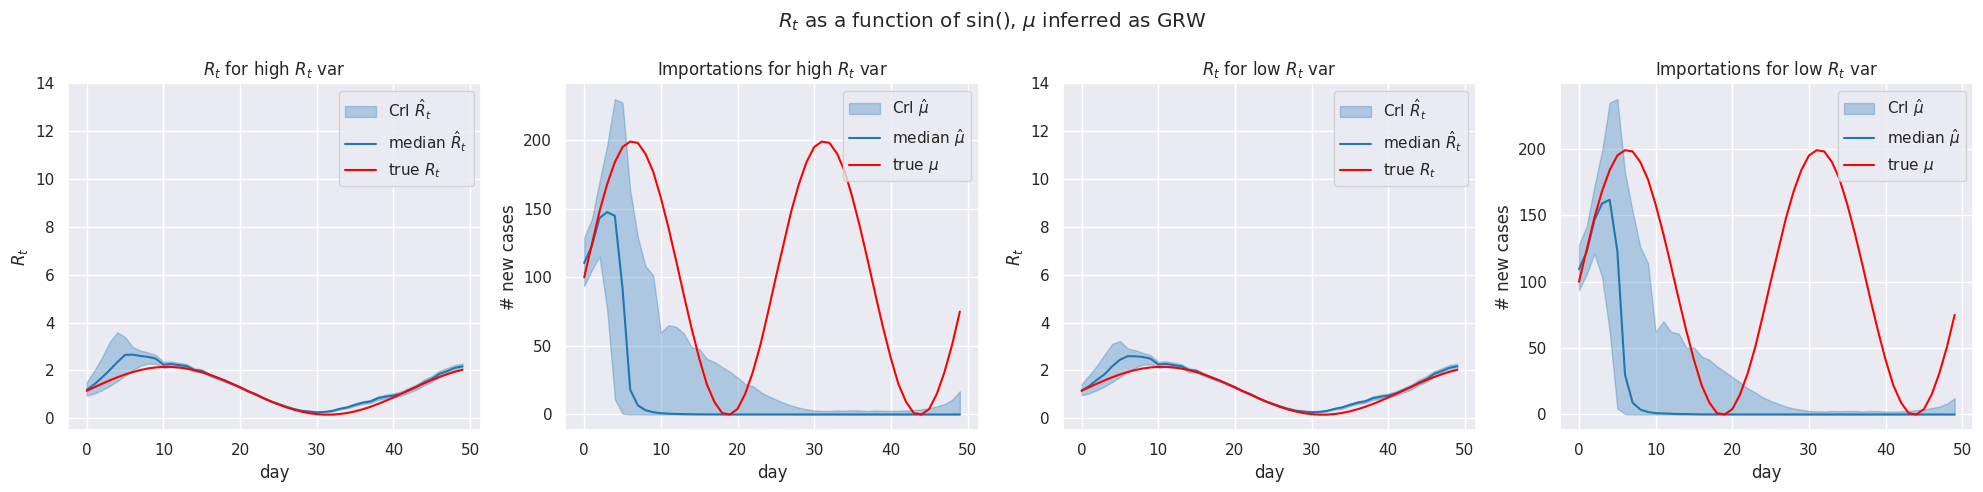

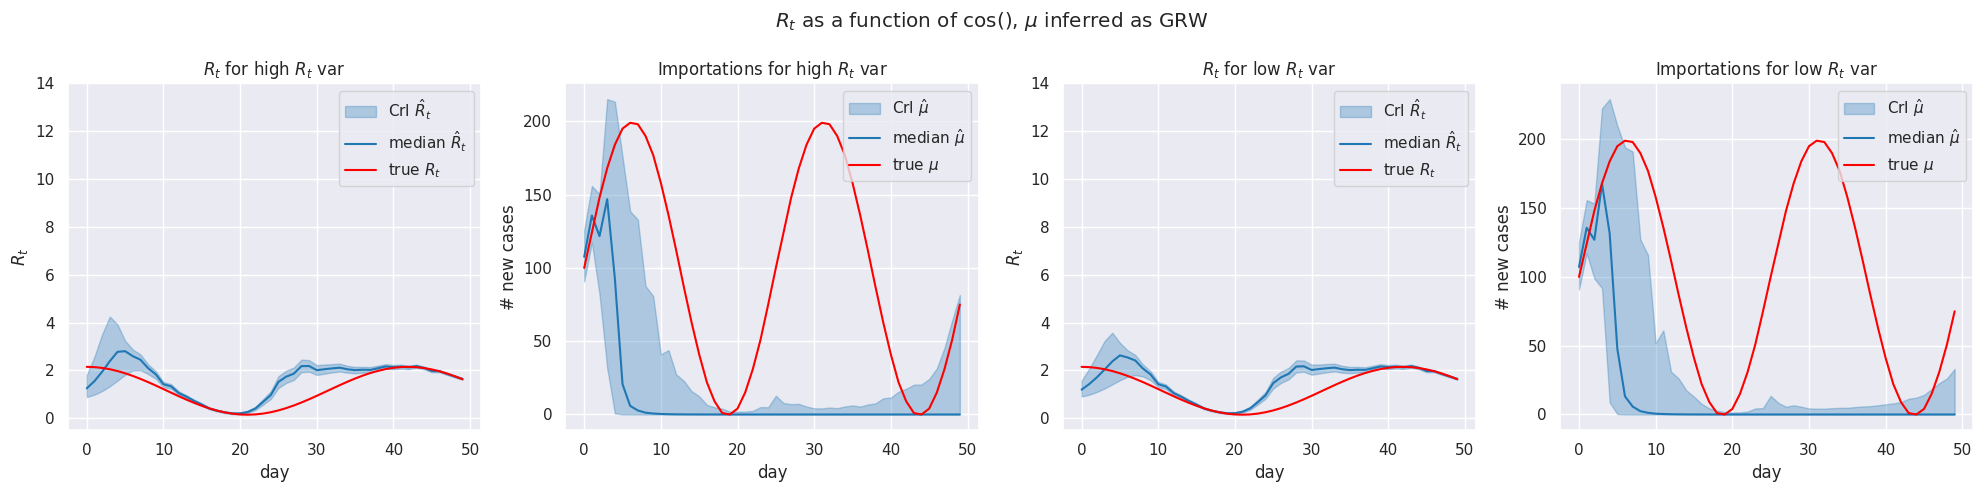

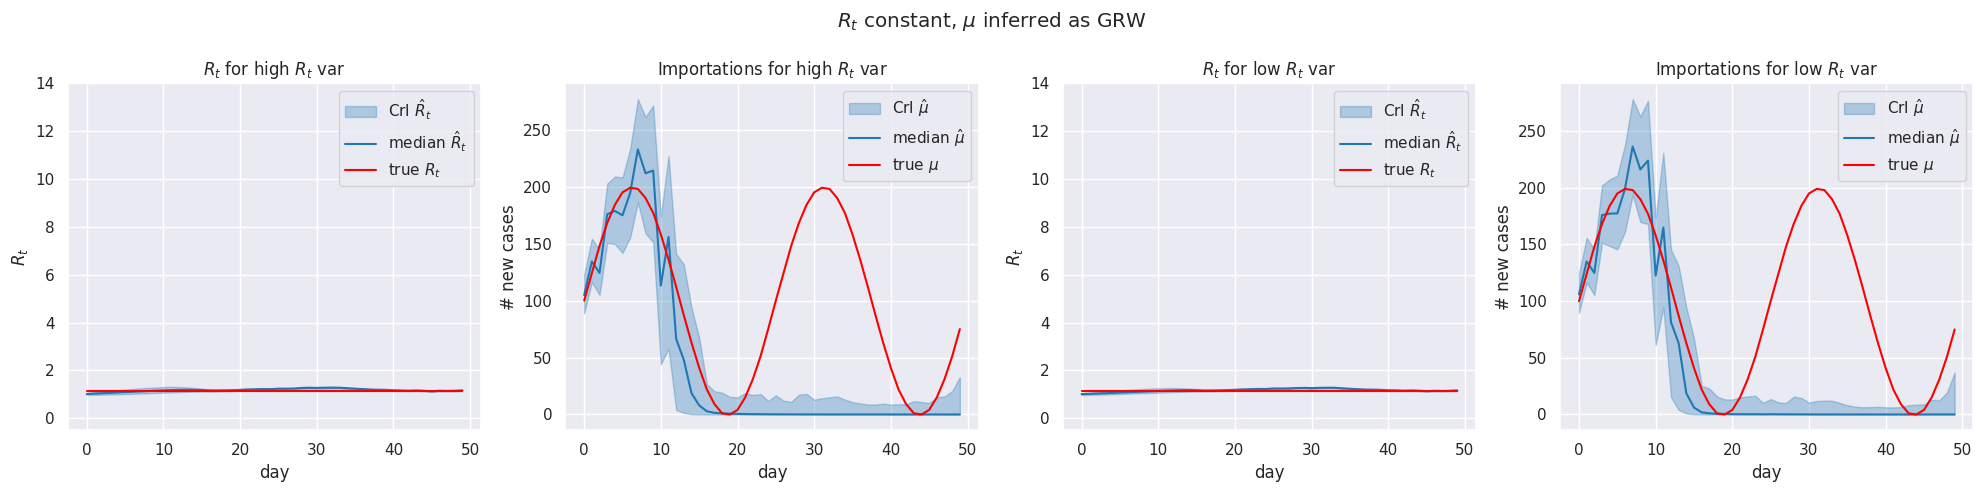

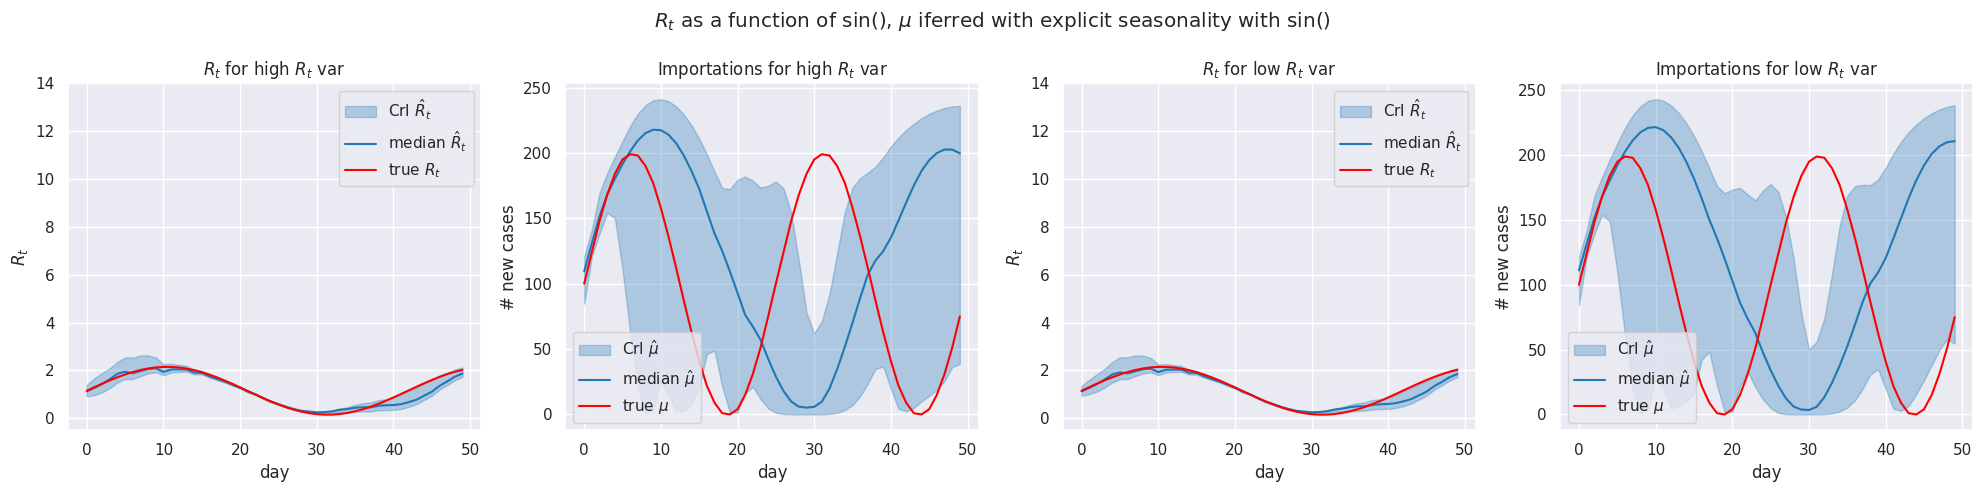

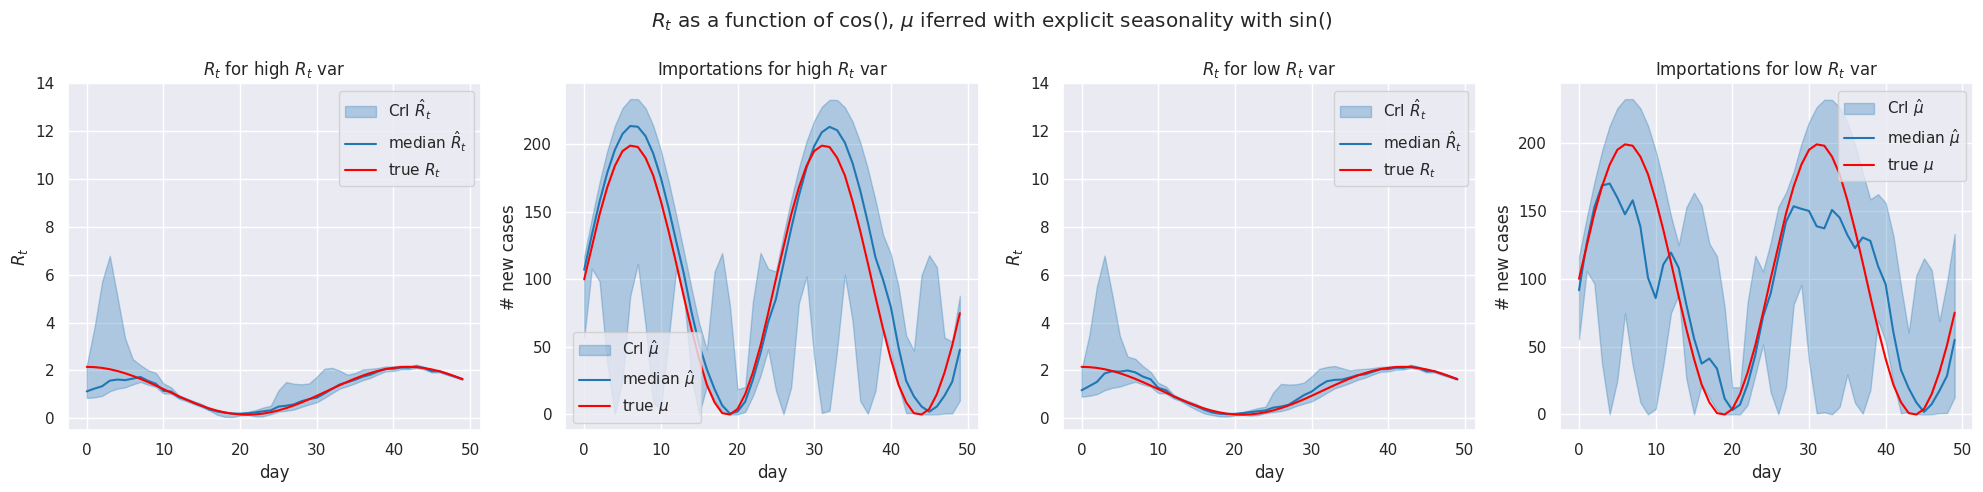

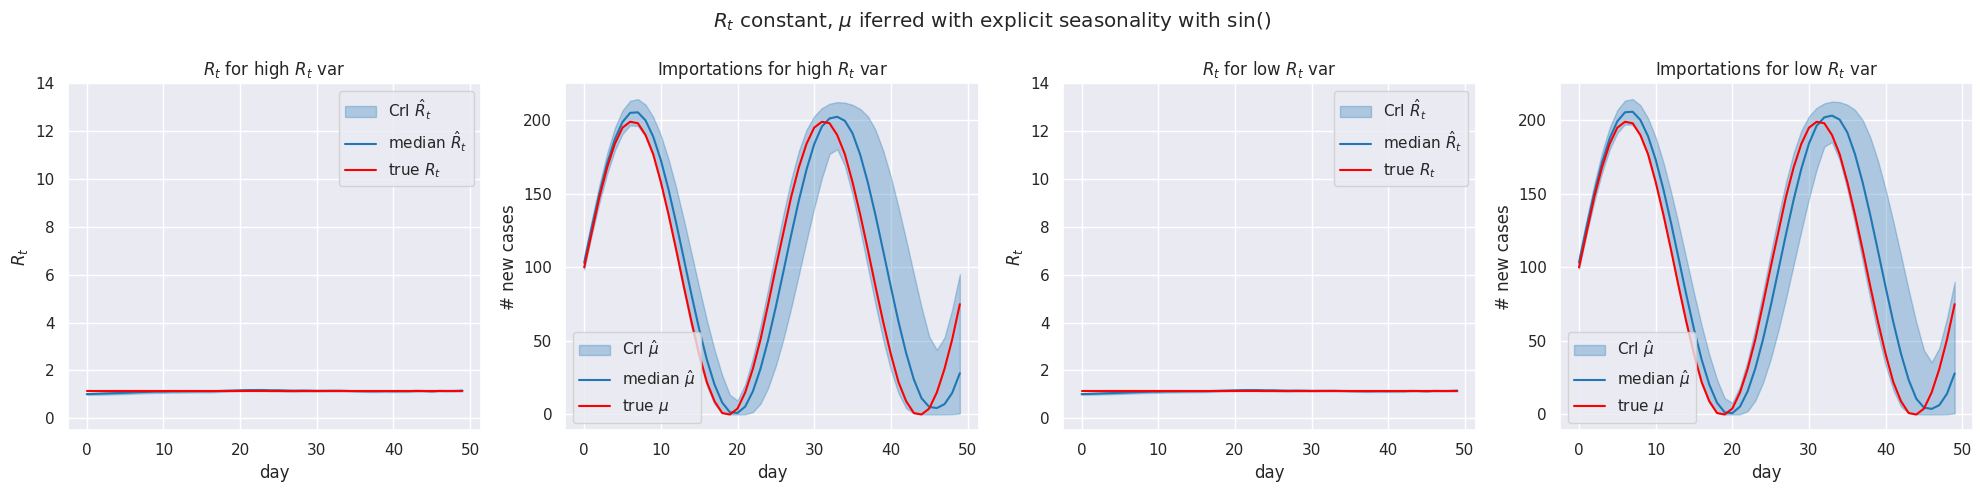

In [ ]:
plot_posterior_two_samples_no_incidence(mcmc1, mcmc10, Rt_df['R1'], mu_df['mu1'], y_df['y1'], title=scenarios_names[1])
plot_posterior_two_samples_no_incidence(mcmc2, mcmc20, Rt_df['R2'], mu_df['mu2'], y_df['y2'], title=scenarios_names[2])
plot_posterior_two_samples_no_incidence(mcmc3, mcmc30, Rt_df['R3'], mu_df['mu3'], y_df['y3'], title=scenarios_names[3])

plot_posterior_two_samples_no_incidence(mcmc1e, mcmc10e, Rt_df['R1'], mu_df['mu1'], y_df['y1'], title=scenarios_names_e[1])
plot_posterior_two_samples_no_incidence(mcmc2e, mcmc20e, Rt_df['R2'], mu_df['mu2'], y_df['y2'], title=scenarios_names_e[2])
plot_posterior_two_samples_no_incidence(mcmc3e, mcmc30e, Rt_df['R3'], mu_df['mu3'], y_df['y3'], title=scenarios_names_e[3])

# Plot true Rt vs predicted Rt

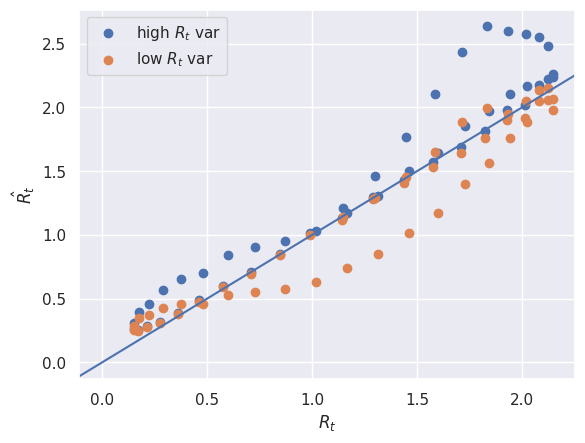

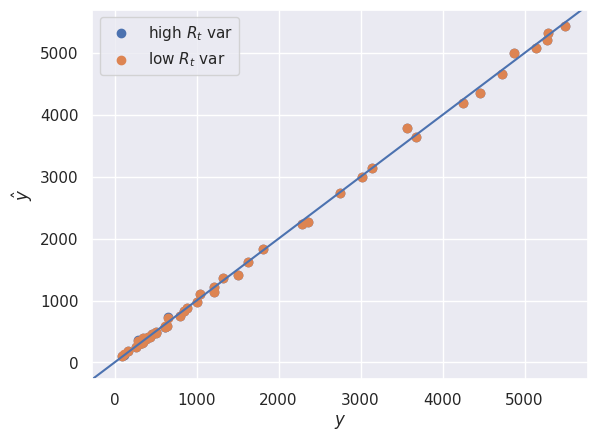

In [ ]:
def plot_Rt_true_vs_pred(mcmc_high, mcmc_low, log_scale=False):
  true = Rt_df['R1'] # all columns are the same so doesn't matter which one we take
  pred_high = mcmc_high.get_samples()['R']
  pred_low = mcmc_low.get_samples()['R']
  plt.scatter(true, pred_high.mean(axis=0), label = r'high $R_t$ var')
  plt.scatter(true, pred_low.mean(axis=0), label = r'low $R_t$ var')
  plt.xlabel(r'$R_t$')
  plt.ylabel(r'$\hat{R_t}$')
  plt.axline((0, 0), slope=1)
  if log_scale:
    plt.yscale('log')
    plt.xscale('log')
  plt.legend()
  plt.show()

plot_Rt_true_vs_pred(mcmc1, mcmc1e)


def plot_y_true_vs_pred(y_label, mcmc_high, mcmc_low, log_scale=False):
  true = y_df[y_label]
  pred_high = mcmc_high.get_samples()['incidence']
  pred_low = mcmc_low.get_samples()['incidence']
  plt.scatter(true, pred_high.mean(axis=0), label = r'high $R_t$ var')
  plt.scatter(true, pred_low.mean(axis=0), label = r'low $R_t$ var')
  plt.xlabel(r'$y$')
  plt.ylabel(r'$\hat{y}$')
  plt.axline((0, 0), slope=1)
  if log_scale:
    plt.yscale('log')
    plt.xscale('log')
  plt.legend()
  plt.show()

plot_y_true_vs_pred('y1', mcmc1, mcmc1e)


# (R)MSE


In [ ]:
def plot_mse_Rt(mcmc_high, mcmc_low, squared = True, log_scale=False):
  # if squared = True then it is MSE
  # if squared = False then it is RMSE
  true = Rt_df['R1'] # all columns are the same so doesn't matter which one we take
  pred_high = mcmc_high.get_samples()['R']
  pred_low = mcmc_low.get_samples()['R']

  true = np.array(true)
  n = pred_high.shape[0]
  true = np.tile(true, n).reshape(pred_high.shape)

  mse_high = mse(true, pred_high, multioutput='raw_values', squared = squared)
  mse_low = mse(true, pred_low, multioutput='raw_values', squared = squared)

  plt.plot(mse_high, label=(r'high $R_t$ var'))
  plt.plot(mse_low, label=(r'low $R_t$ var'))
  plt.legend()
  plt.xlabel('day')
  ylabel = 'MSE for $R_t$'
  if not squared:
    ylabel = 'R' + ylabel
  if log_scale:
    plt.yscale('log')
    ylabel = 'log-' + ylabel
  plt.ylabel(ylabel)
  # plt.show()

def plot_mse_y(true, mcmc_high, mcmc_low, squared = True, log_scale=False):
  # if squared = True then it is MSE
  # if squared = False then it is RMSE
  pred_high = mcmc_high.get_samples()['incidence']
  pred_low = mcmc_low.get_samples()['incidence']

  true = np.array(true)
  n = pred_high.shape[0]
  true = np.tile(true, n).reshape(pred_high.shape)

  mse_high = mse(true, pred_high, multioutput='raw_values', squared = squared)
  mse_low = mse(true, pred_low, multioutput='raw_values', squared = squared)

  plt.plot(mse_high, label=(r'high $R_t$ var'))
  plt.plot(mse_low, label=(r'low $R_t$ var'))
  plt.legend()
  plt.xlabel('day')
  ylabel = 'MSE for incidence'
  if not squared:
    ylabel = 'R' + ylabel
  if log_scale:
    plt.yscale('log')
    ylabel = 'log-' + ylabel
  plt.ylabel(ylabel)
  # plt.show()

def plot_mse_mu(true, mcmc_high, mcmc_low, squared = True, log_scale=False):
  # if squared = True then it is MSE
  # if squared = False then it is RMSE
  pred_high = mcmc_high.get_samples()['mu']
  pred_low = mcmc_low.get_samples()['mu']

  true = np.array(true)
  n = pred_high.shape[0]
  true = np.tile(true, n).reshape(pred_high.shape)

  mse_high = mse(true, pred_high, multioutput='raw_values', squared = squared)
  mse_low = mse(true, pred_low, multioutput='raw_values', squared = squared)

  plt.plot(mse_high, label=(r'high $R_t$ var'))
  plt.plot(mse_low, label=(r'low $R_t$ var'))
  plt.legend()
  plt.xlabel('day')
  ylabel = 'MSE for importations'
  if not squared:
    ylabel = 'R' + ylabel
  if log_scale:
    plt.yscale('log')
    ylabel = 'log-' + ylabel
  plt.ylabel(ylabel)
  # plt.show()


def plot_mse_Rt_and_y_and_mu(title, true_y, true_mu, mcmc_high, mcmc_low, squared = True, log_scale=False):
  plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plot_mse_Rt(mcmc_high, mcmc_low, squared = squared, log_scale=log_scale)
  plt.subplot(1,3,2)
  plot_mse_y(true_y, mcmc_high, mcmc_low, squared = squared, log_scale=log_scale)
  plt.subplot(1,3,3)
  plot_mse_mu(true_mu, mcmc_high, mcmc_low, squared = squared, log_scale=log_scale)
  plt.suptitle(title)
  plt.tight_layout()

  if SAVE:
    namefile = 'MSE_' + title.replace(' ', '_')
    plt.savefig(savepath + namefile + '.pdf', format = 'pdf', bbox_inches = 'tight')

  else:
    plt.show()


## Plot (R)MSE for R_t, incidence and importations

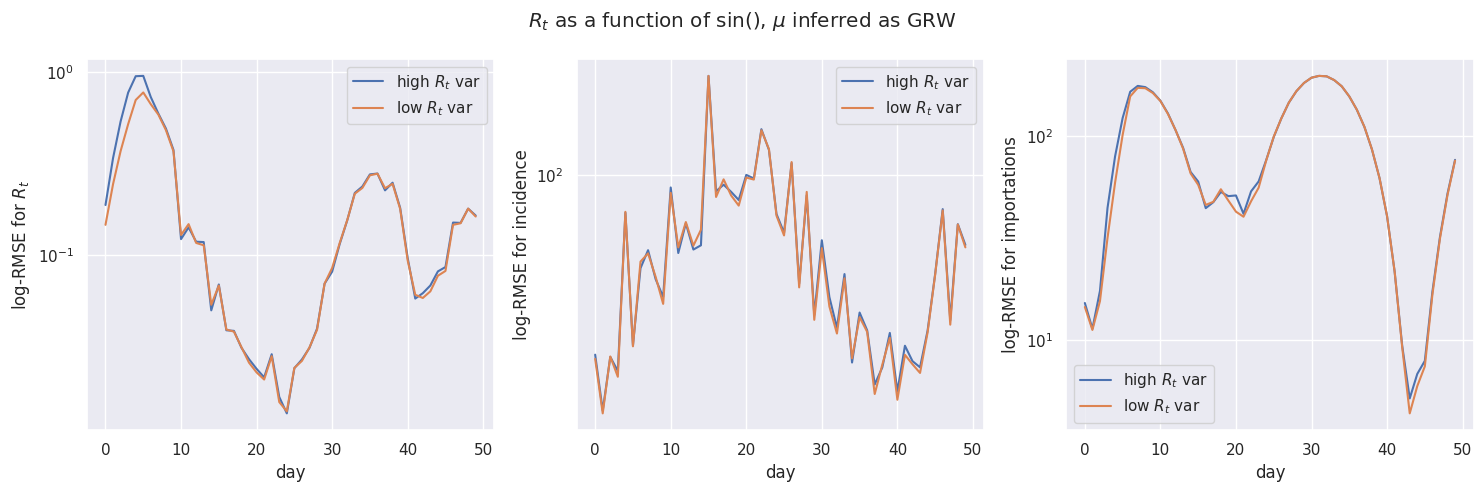

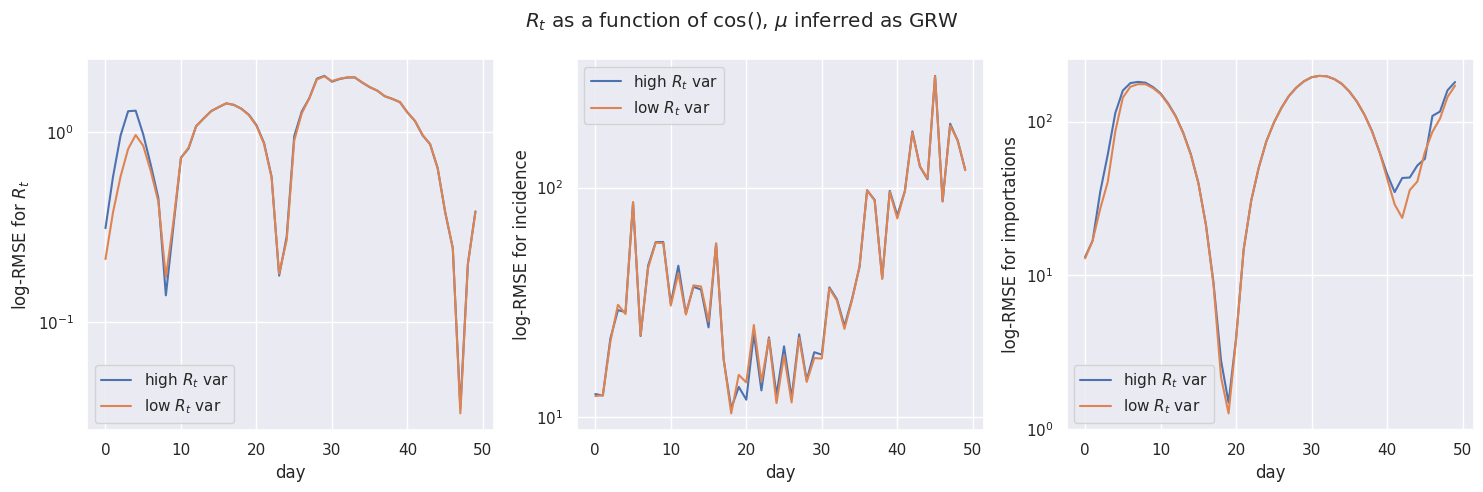

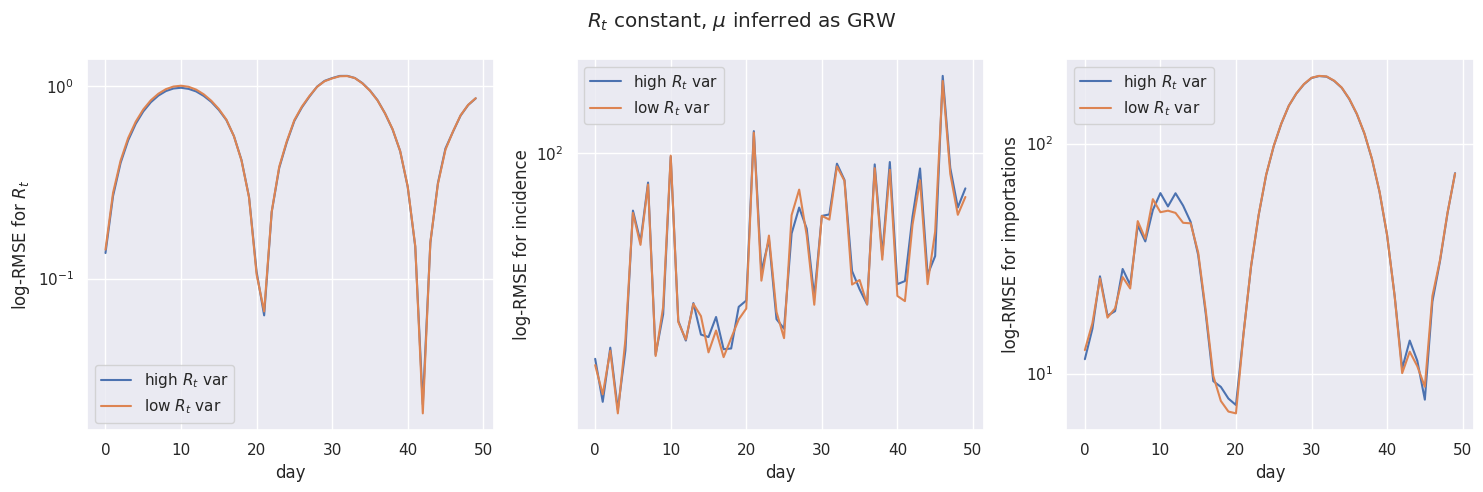

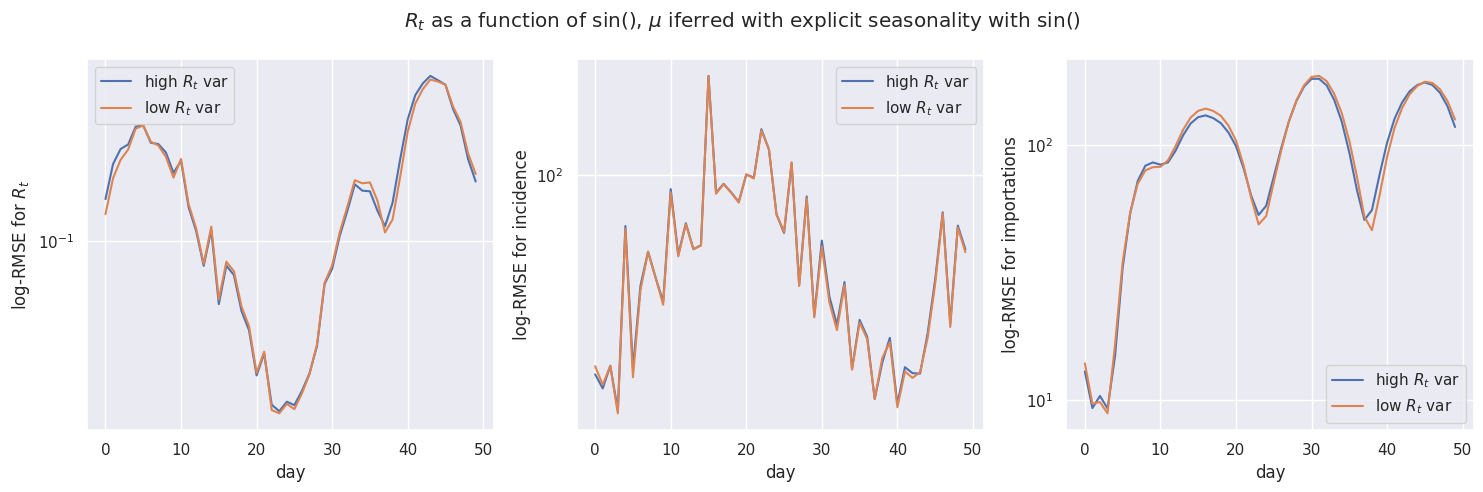

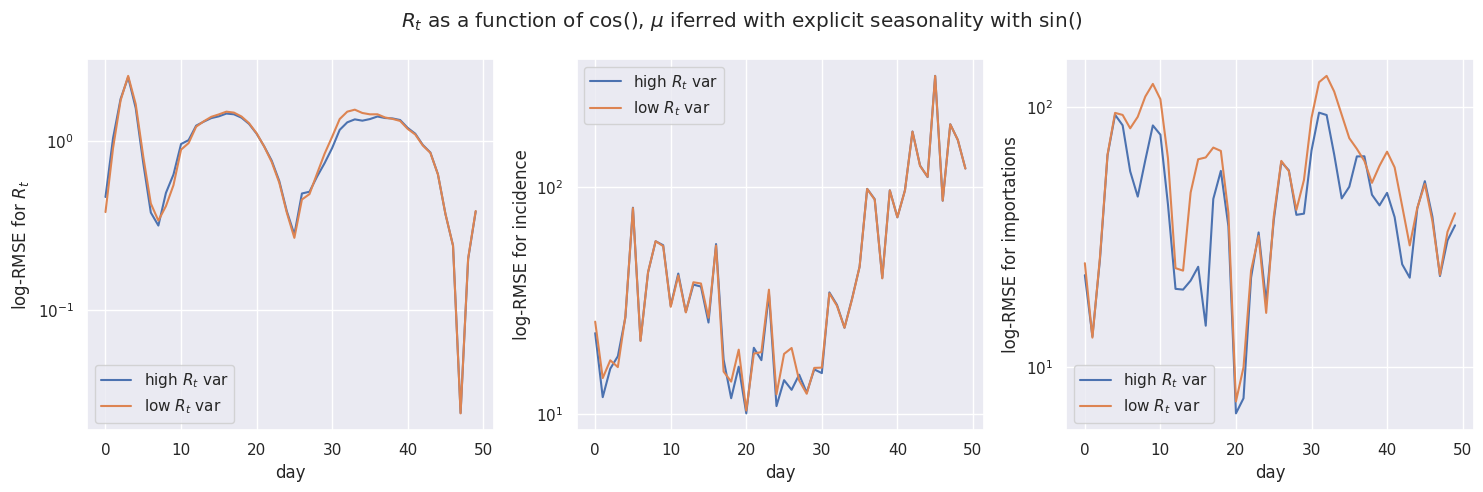

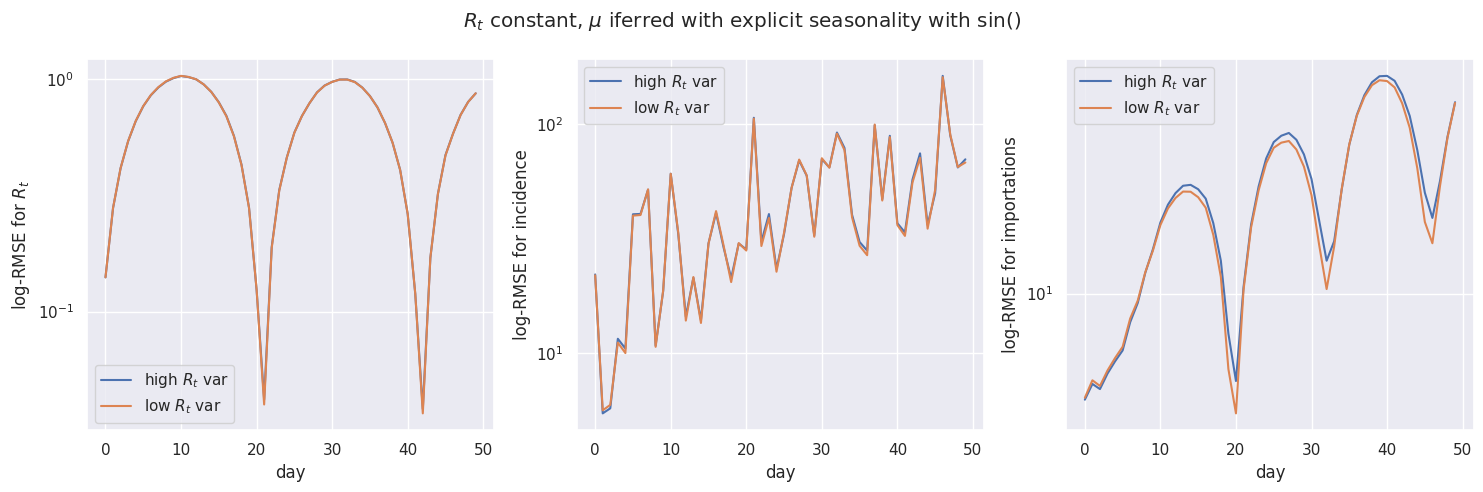

In [ ]:
squared = False # calculate RMSE
log_scale = True  # on a log-scale

plot_mse_Rt_and_y_and_mu(scenarios_names[1], y_df['y1'], mu_df['mu1'], mcmc1, mcmc10, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names[2], y_df['y2'], mu_df['mu2'], mcmc2, mcmc20, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names[3], y_df['y3'], mu_df['mu3'], mcmc3, mcmc30, squared = squared, log_scale=log_scale)

plot_mse_Rt_and_y_and_mu(scenarios_names_e[1], y_df['y1'], mu_df['mu1'], mcmc1e, mcmc10e, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names_e[2], y_df['y2'], mu_df['mu2'], mcmc2e, mcmc20e, squared = squared, log_scale=log_scale)
plot_mse_Rt_and_y_and_mu(scenarios_names_e[3], y_df['y3'], mu_df['mu3'], mcmc3e, mcmc30e, squared = squared, log_scale=log_scale)


# MCMC diagnostics

I can only obtain a print statement, the specific values have to be fished out of that

In [ ]:
mcmc1.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    R_d[0]      0.18      0.14      0.18     -0.06      0.42  13519.43      1.00
    R_d[1]      0.36      0.20      0.36      0.03      0.69   9066.00      1.00
    R_d[2]      0.54      0.24      0.54      0.15      0.92   6103.43      1.00
    R_d[3]      0.71      0.26      0.70      0.28      1.14   4574.15      1.00
    R_d[4]      0.86      0.25      0.86      0.47      1.31   4831.83      1.00
    R_d[5]      0.95      0.20      0.97      0.63      1.25   4826.08      1.00
    R_d[6]      0.95      0.12      0.98      0.76      1.12   5595.48      1.00
    R_d[7]      0.94      0.08      0.96      0.83      1.06   6353.24      1.00
    R_d[8]      0.93      0.06      0.94      0.85      1.03   5663.67      1.00
    R_d[9]      0.91      0.05      0.91      0.84      0.98   6632.13      1.00
   R_d[10]      0.80      0.04      0.81      0.75      0.86   8450.01      1.00
   R_d[11]      0.82      0

# CRPS

In [ ]:
true = np.array(Rt_df['R1'])
pred = mcmc1.get_samples()['R']
n = pred.shape[0]
true = np.tile(true, n).reshape(pred.shape)

# mse_high = mse(true, pred_high, multioutput='raw_values', squared = squared)

In [ ]:
print(pred.shape)
print(crps(true, pred).shape)
print(crps(true, pred).mean(axis=0).shape)

(80000, 50)
(80000, 50)
(50,)


In [ ]:
# def get_crps_Rt(mcmc_high, mcmc_low, log_scale=False):
#   true = Rt_df['R1'] # all columns are the same so doesn't matter which one we take
#   pred_high = mcmc_high.get_samples()['R']
#   pred_low = mcmc_low.get_samples()['R']

#   return crps(truth, pred_high)



# crps(truth, samples)